## Database filtering

Data filtering the visual database related to rat's behavior - removal of movement interrupting acuity tests:
1. Rearing
2. Scratching
3. Moving around

In [1]:
# data loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats, integrate

%matplotlib inline
sns.set(color_codes=True)

path = '../datasets/'

dfrat = pd.read_hdf(path+'relationalDatabase.h5', 'Rat_Behavior').set_index('index')

hyperparam = { 'BPFlimit' : 0.5 ,
               'LPFlimit' : 0.13,
               'MOVElimit': 0.02,}


## Rearing removal
Removal based on Y axis postion limit - low pass filter

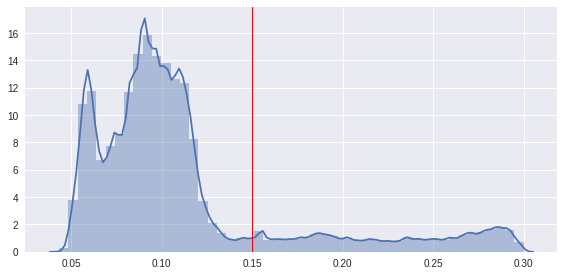

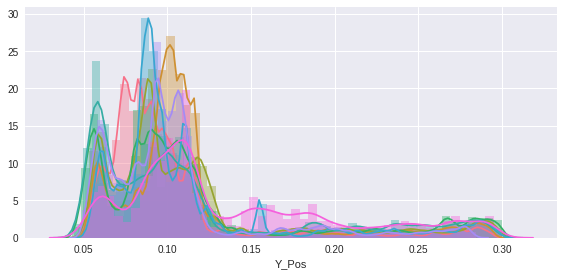

In [2]:
g = sns.FacetGrid(data=dfrat, size=4, aspect=2)
g.map(sns.distplot, 'Y_Pos');
g.map(plt.axvline, x=0.15, alpha=1, linewidth=1, color='red');


g = sns.FacetGrid(hue='session_id', data=dfrat, size=4, aspect=2)
g.map(sns.distplot, 'Y_Pos');

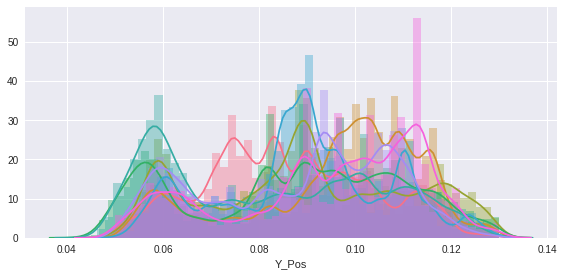

In [3]:
# Low pass filetring of Y position
rearinglimit = 0.13
dfratnew = dfrat[dfrat['Y_Pos'] < rearinglimit]

# Plotting after filtering
g = sns.FacetGrid(hue='session_id', data=dfratnew, size=4, aspect=2)
g.map(sns.distplot, 'Y_Pos');

## Scratching and cleaning removal
Removal based on Y axis orientation limit - band pass filter

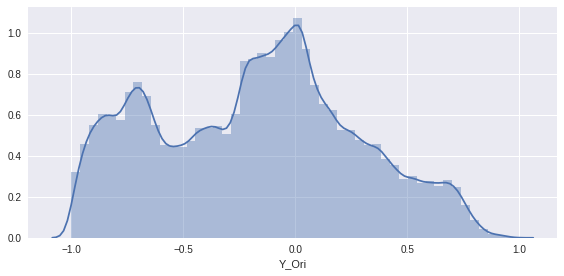

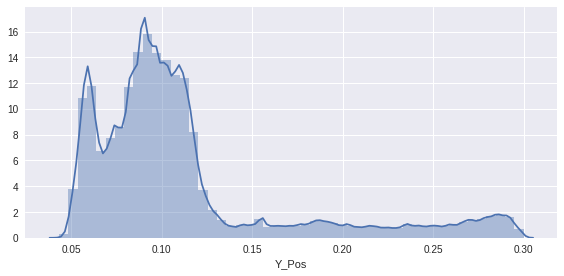

In [4]:
## MY THEORY: removing when Y_Ori smaller then this and Y_Pos smaller
# there are two bumps: show them, show finding them and then remove what smaller then that barrier , problem with red(higher rat?)
# then show after the bump 'removal', different distr -> but only when they are both smaller in position and orientation

g = sns.FacetGrid(data=dfrat, size=4, aspect=2)
g.map(sns.distplot, 'Y_Ori');

g = sns.FacetGrid(data=dfrat, size=4, aspect=2)
g.map(sns.distplot, 'Y_Pos');

'''
 two bumps in both pos iton and orietnation:
 1. find a min between ori 0:-1  in distribution
 2.  compare it with the cut in y position for each rat
 3. if it works for all distributions, it seems that 

'''

'\n two bumps in both pos iton and orietnation:\n 1. find a min between ori 0:-1  in distribution\n 2.  compare it with the cut in y position for each rat\n 3. if it works for all distributions, it seems that \n\n'

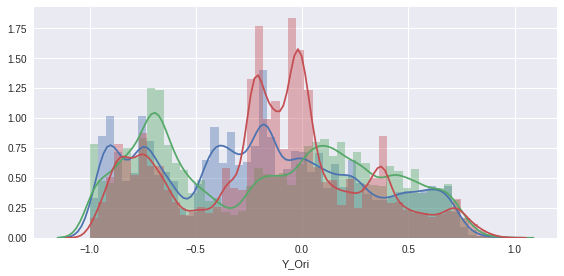

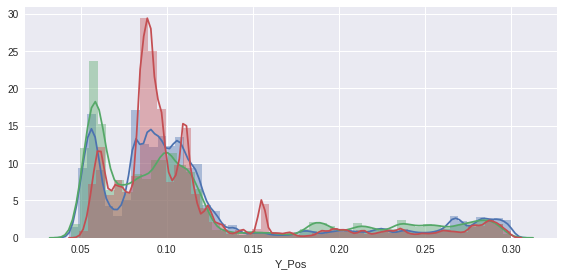

In [5]:
g = sns.FacetGrid(hue='session_id', data=dfrat, size=4, aspect=2, hue_order=[3,4,5])
g.map(sns.distplot, 'Y_Ori');

g = sns.FacetGrid(hue='session_id', data=dfrat, size=4, aspect=2, hue_order=[3,4,5])
g.map(sns.distplot, 'Y_Pos');

In [6]:
halfdat = dfrat.copy()
halfdat = halfdat[halfdat['Y_Ori']<0]

# by hand for one of the experiments
filtdat = dfrat.copy()
filtdat = filtdat[filtdat['Y_Ori'] > -0.6]

filtdatrear = dfratnew.copy()
filtdatrear = filtdatrear[filtdatrear['Y_Ori'] > -0.6]


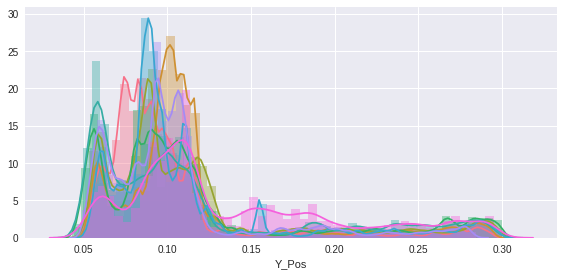

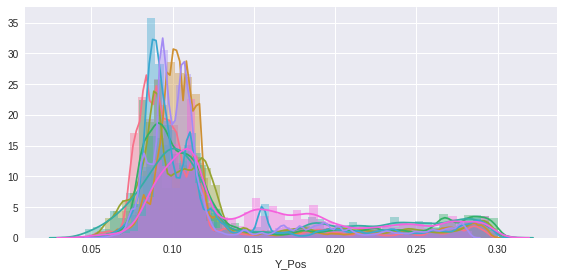

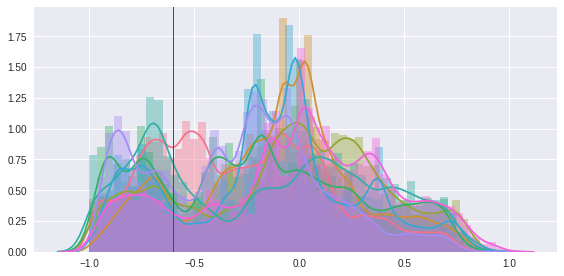

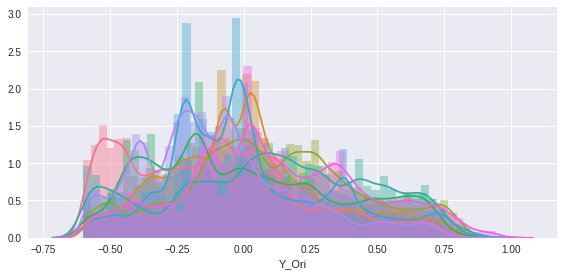

In [23]:
# g = sns.FacetGrid(hue='session_id', data=dfrat, size=4, aspect=2, hue_order=[4,])
g = sns.FacetGrid(hue='session_id', data=dfrat, size=4, aspect=2, )
g.map(sns.distplot, 'Y_Pos');

# g = sns.FacetGrid(hue='session_id', data=filtdat, size=4, aspect=2, hue_order=[4,])
g = sns.FacetGrid(hue='session_id', data=filtdat, size=4, aspect=2)
g.map(sns.distplot, 'Y_Pos');

g = sns.FacetGrid(hue='session_id', data=dfrat, size=4, aspect=2, )
# g = sns.FacetGrid(hue='session_id', data=dfrat, size=4, aspect=2, hue_order=[4,])
g.map(sns.distplot, 'Y_Ori');
g.map(plt.axvline, x=-0.6, alpha=1, linewidth=1, color='red');

g = sns.FacetGrid(hue='session_id', data=filtdat, size=4, aspect=2, )
# g = sns.FacetGrid(hue='session_id', data=filtdat, size=4, aspect=2, hue_order=[4,])
g.map(sns.distplot, 'Y_Ori');


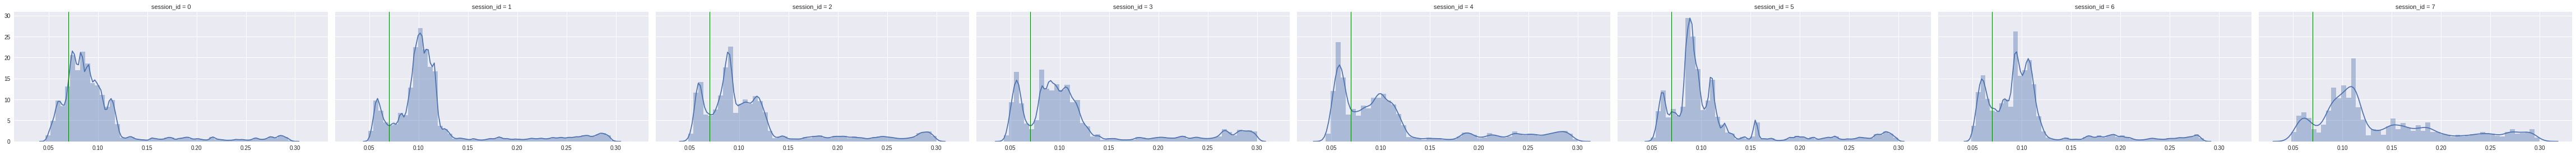

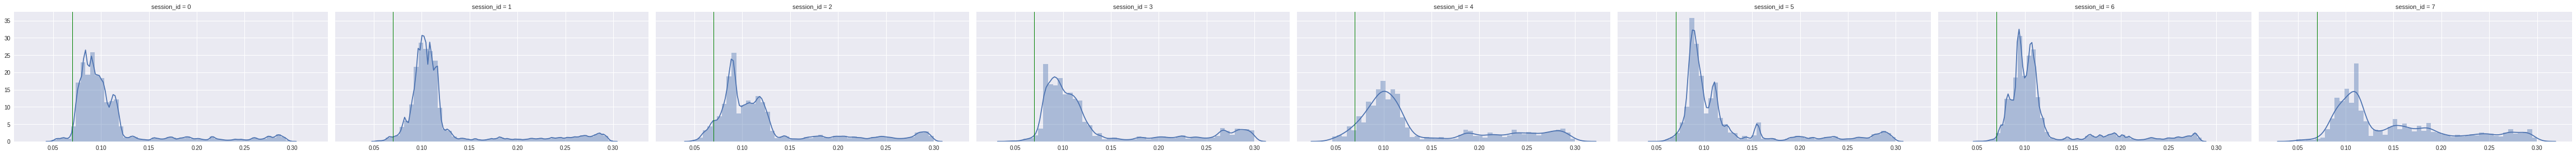

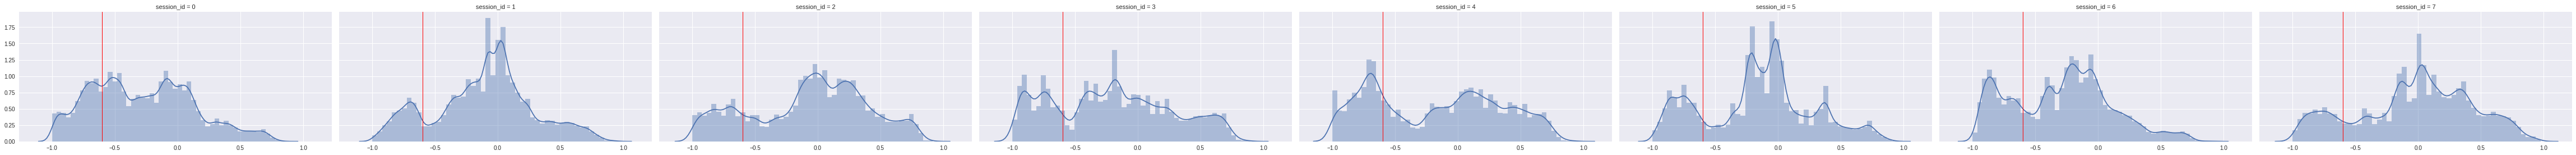

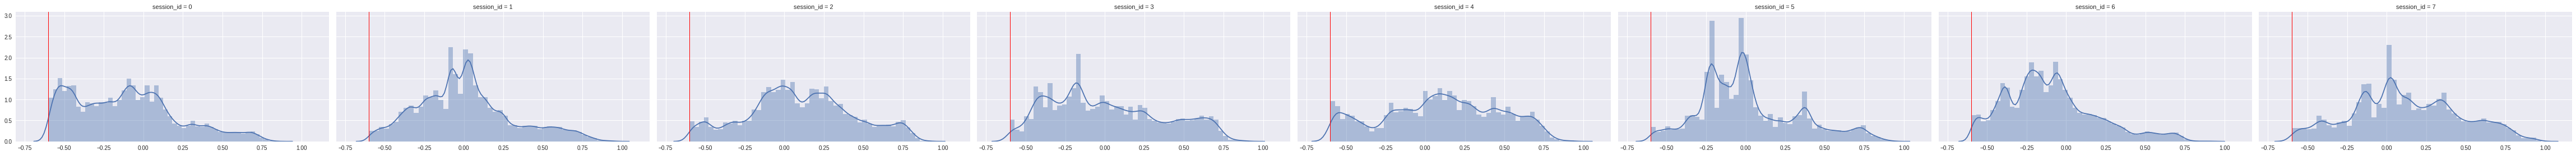

In [26]:
g = sns.FacetGrid(col='session_id', data=dfrat, size=4, aspect=2, )
g.map(sns.distplot, 'Y_Pos');
g.map(plt.axvline, x=0.07, alpha=1, linewidth=1, color='green');

# g = sns.FacetGrid(hue='session_id', data=filtdat, size=4, aspect=2, hue_order=[4,])
g = sns.FacetGrid(col='session_id', data=filtdat, size=4, aspect=2)
g.map(sns.distplot, 'Y_Pos');
g.map(plt.axvline, x=0.07, alpha=1, linewidth=1, color='green');

g = sns.FacetGrid(col='session_id', data=dfrat, size=4, aspect=2, )
# g = sns.FacetGrid(hue='session_id', data=dfrat, size=4, aspect=2, hue_order=[4,])
g.map(sns.distplot, 'Y_Ori');
g.map(plt.axvline, x=-0.6, alpha=1, linewidth=1, color='red');


g = sns.FacetGrid(col='session_id', data=filtdat, size=4, aspect=2, )
# g = sns.FacetGrid(hue='session_id', data=filtdat, size=4, aspect=2, hue_order=[4,])
g.map(sns.distplot, 'Y_Ori');
g.map(plt.axvline, x=-0.6, alpha=1, linewidth=1, color='red');


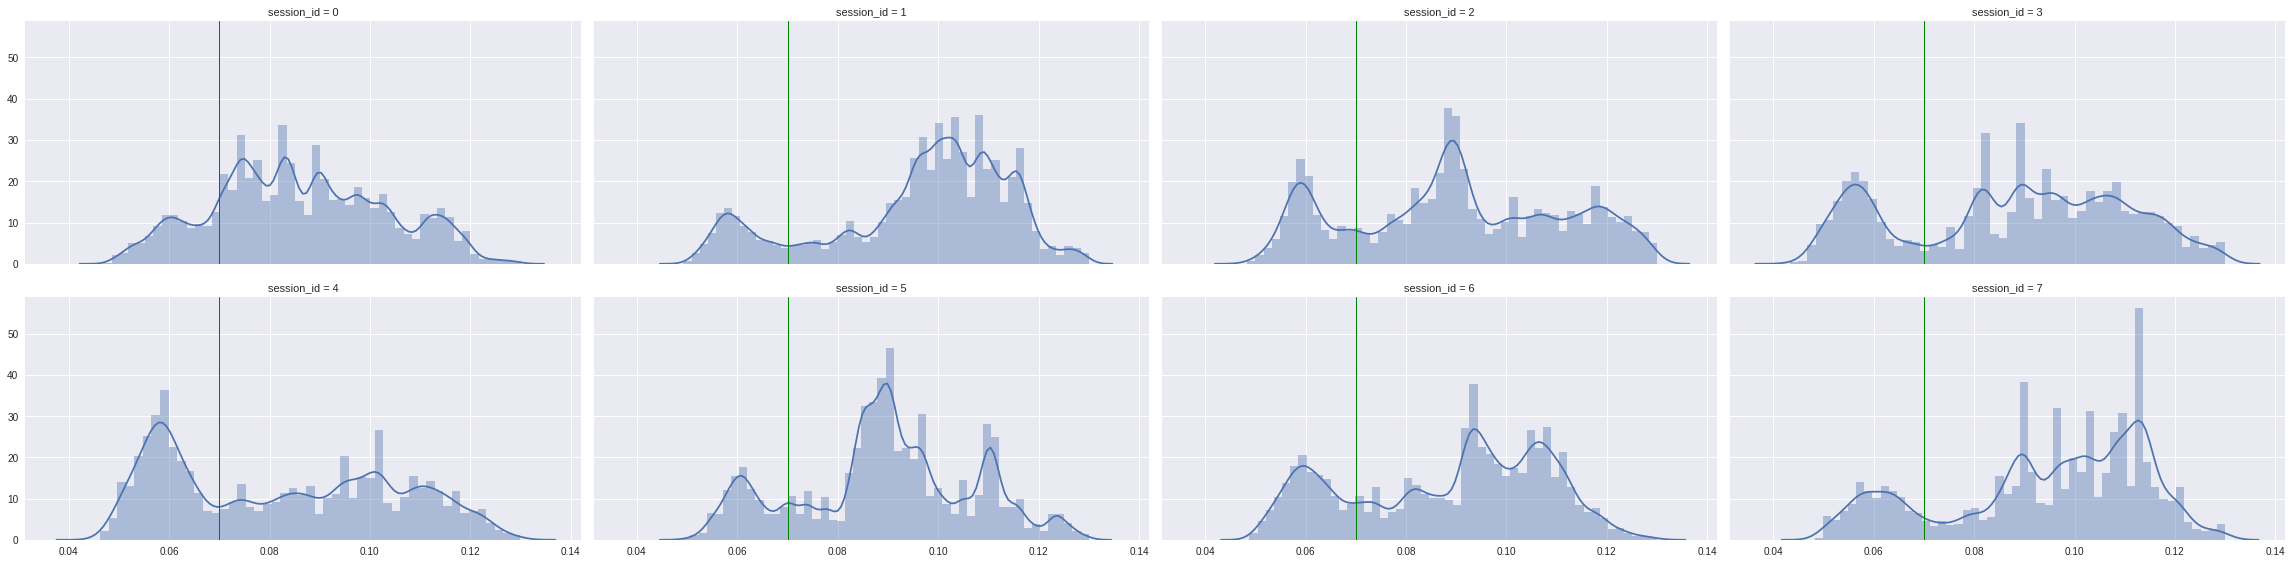

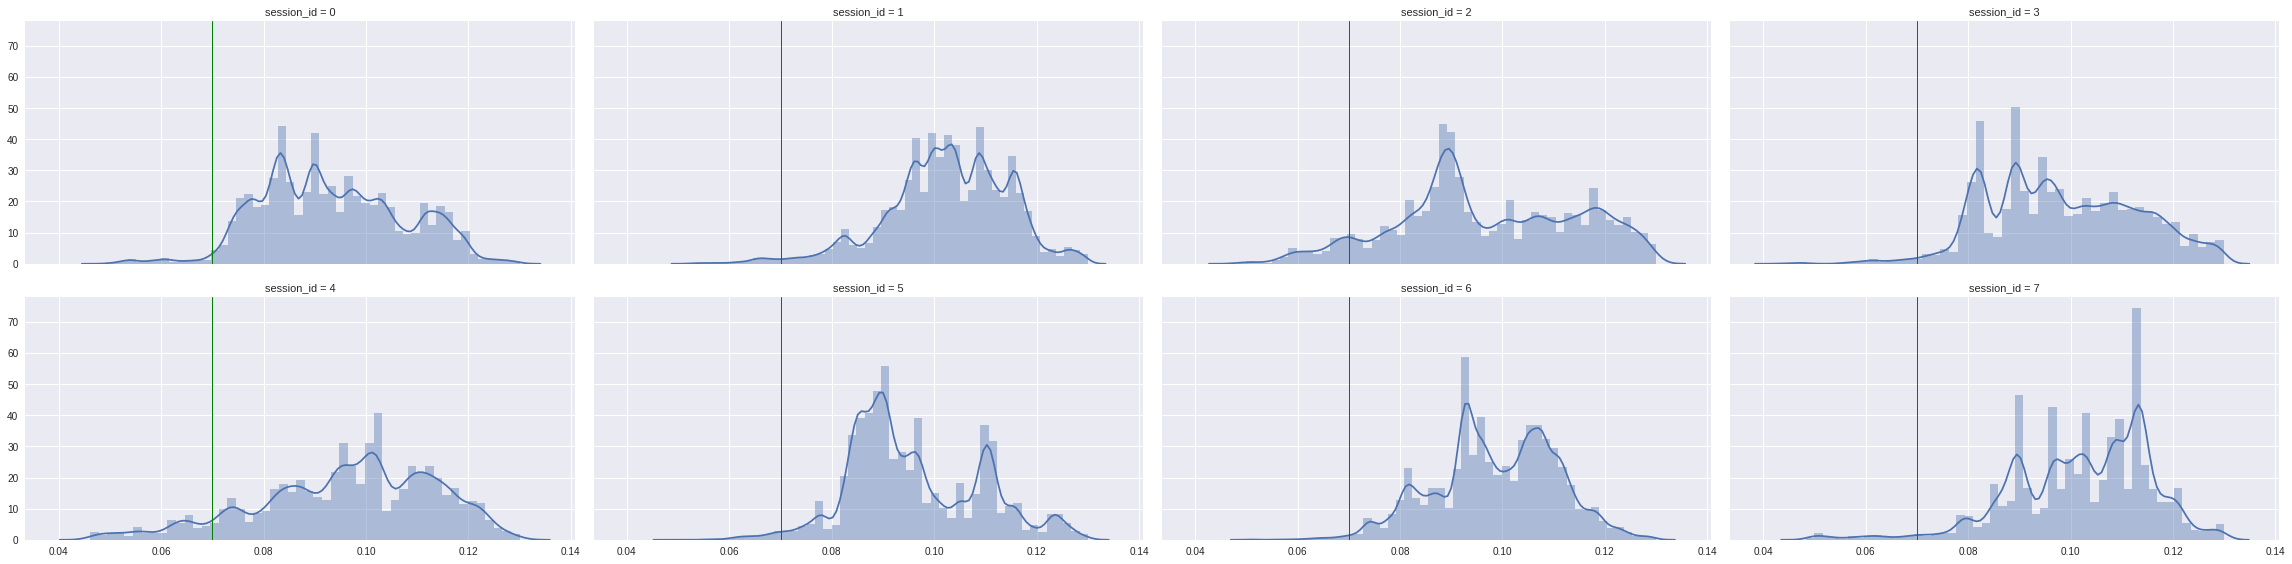

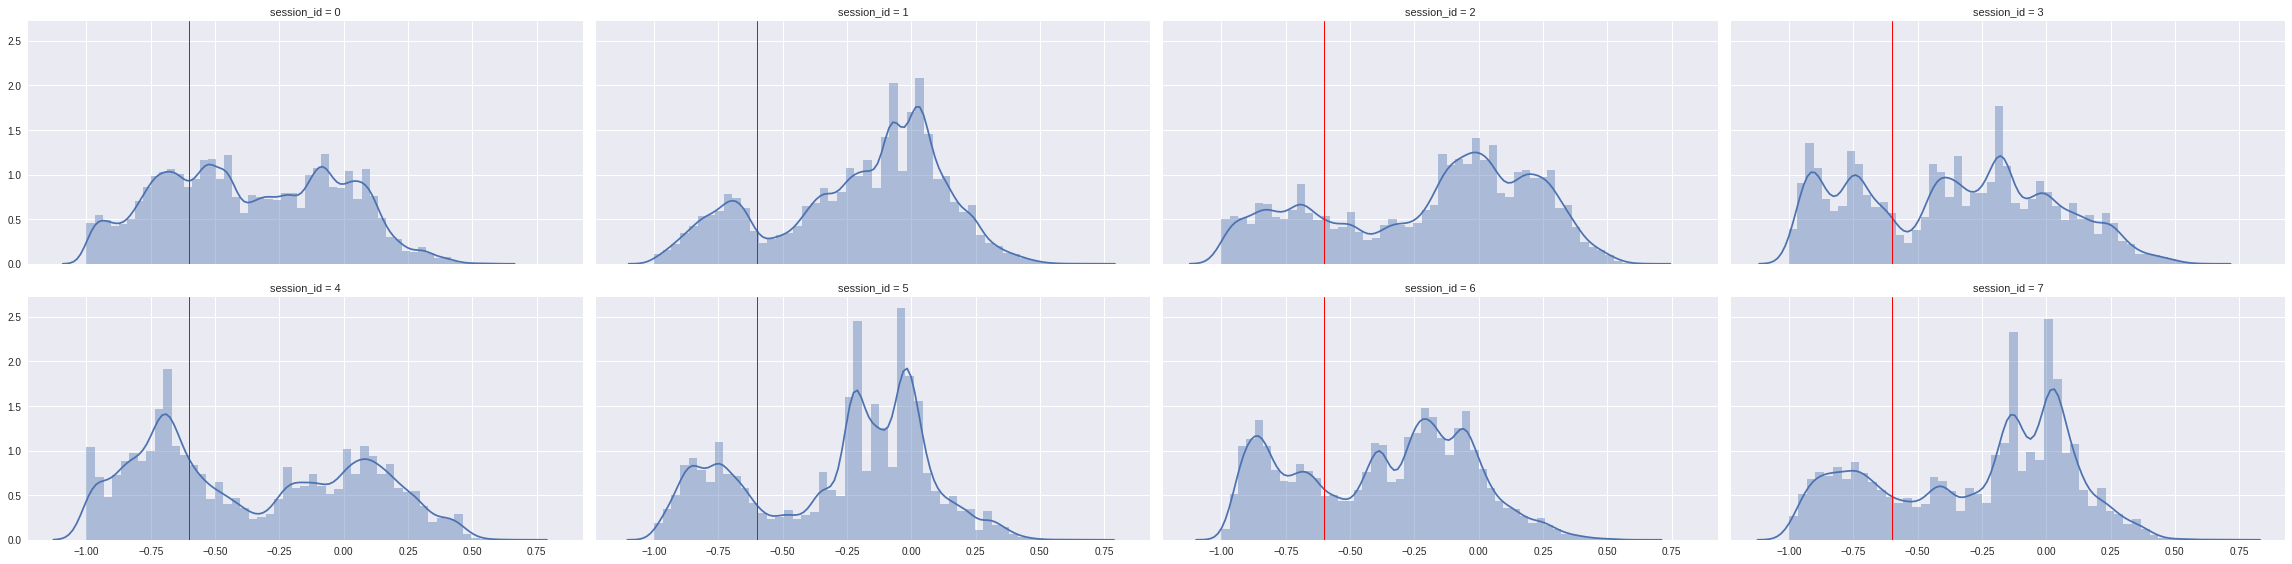

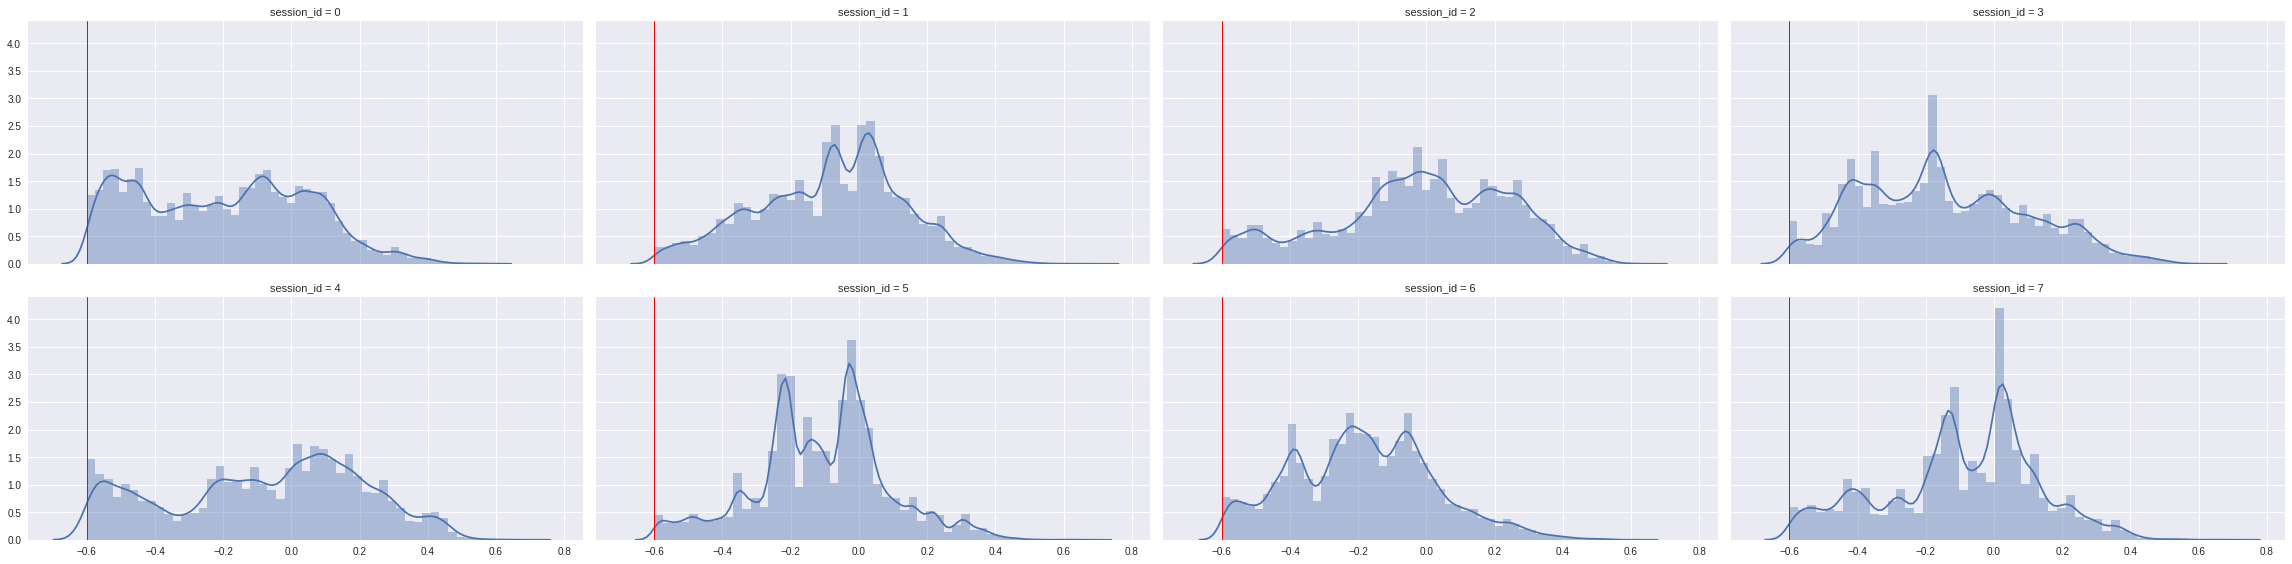

In [31]:
g = sns.FacetGrid(col='session_id', data=dfratnew, size=4, aspect=2,col_wrap=4 )
g.map(sns.distplot, 'Y_Pos');
g.map(plt.axvline, x=0.07, alpha=1, linewidth=1, color='green');

g = sns.FacetGrid(col='session_id', data=filtdatrear, size=4, aspect=2,col_wrap=4)
g.map(sns.distplot, 'Y_Pos');
g.map(plt.axvline, x=0.07, alpha=1, linewidth=1, color='green');

# ORIENTATION
g = sns.FacetGrid(col='session_id', data=dfratnew, size=4, aspect=2,col_wrap=4 )
g.map(sns.distplot, 'Y_Ori');
g.map(plt.axvline, x=-0.6, alpha=1, linewidth=1, color='red');

g = sns.FacetGrid(col='session_id', data=filtdatrear, size=4, aspect=2,col_wrap=4 )
g.map(sns.distplot, 'Y_Ori');
g.map(plt.axvline, x=-0.6, alpha=1, linewidth=1, color='red');


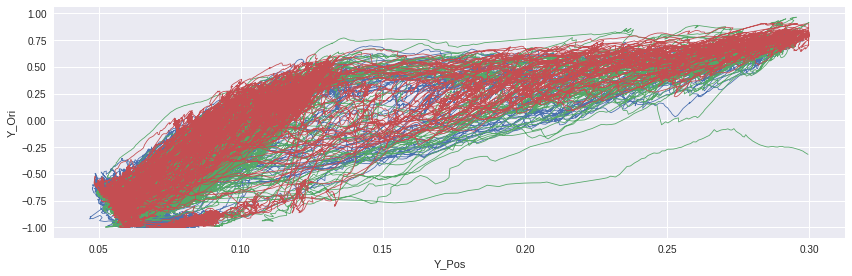

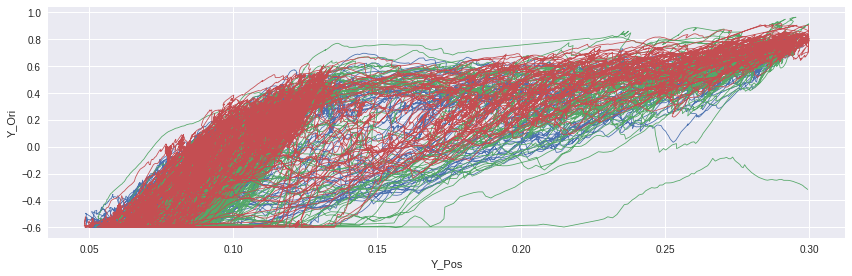

In [10]:
g = sns.FacetGrid(hue='session_id', data=dfrat, size=4, aspect=3, hue_order=[0,1,2])
g.map(plt.plot, "Y_Pos", "Y_Ori", alpha=1, linewidth=0.8);

g = sns.FacetGrid(hue='session_id', data=filtdat, size=4, aspect=3, hue_order=[0,1,2])
g.map(plt.plot, "Y_Pos", "Y_Ori", alpha=1, linewidth=0.8);


In [28]:
# # orientation in time
# g = sns.FacetGrid(hue='session_id', data=dfrat[1000:4000], size=4, aspect=3, hue_order=[1,])
# g.map(plt.plot, "Time", "Y_Ori", alpha=1, linewidth=0.8);

# g = sns.FacetGrid(hue='session_id', data=filtdat[1000:4000], size=4, aspect=3, hue_order=[1,])
# g.map(plt.plot, "Time", "Y_Ori", alpha=1, linewidth=0.8);

# # position in time
# g = sns.FacetGrid(hue='session_id', data=dfrat[1000:4000], size=4, aspect=3, hue_order=[1,])
# g.map(plt.plot, "Time", "Y_Pos", alpha=1, linewidth=0.8);

# g = sns.FacetGrid(hue='session_id', data=filtdat[1000:4000], size=4, aspect=3, hue_order=[1,])
# g.map(plt.plot, "Time", "Y_Pos", alpha=1, linewidth=0.8);

## Smoothing the data

Rolling window applyed on X, Y, Z positiona and orientation data.

In [12]:
windowsize = 200
colChoice = ['X_Pos', 'Y_Pos', 'Z_Pos', 'X_Ori', 'Y_Ori', 'Z_Ori']

df = dfrat.copy()
g = df.groupby('session_id')
df[colChoice] = g[colChoice].rolling(window=windowsize).mean().values


In [13]:
## DATASETS FOR VISUALIZATION
pos_l = dfrat.melt(id_vars=['Frame', 'Time', 'session_id'], 
           value_name='Position', value_vars=['X_Pos', 'Y_Pos', 'Z_Pos'], var_name='Dimension')

ori_l = dfrat.melt(id_vars=['Frame', 'Time', 'session_id'], 
           value_name='Orientation', value_vars=['X_Ori', 'Y_Ori', 'Z_Ori'], var_name='Dimension')

# smoothed data
pos_lSM = df.melt(id_vars=['Frame', 'Time', 'session_id'], 
           value_name='Position', value_vars=['X_Pos', 'Y_Pos', 'Z_Pos'], var_name='Dimension')

ori_lSM = df.melt(id_vars=['Frame', 'Time', 'session_id'], 
           value_name='Orientation', value_vars=['X_Ori', 'Y_Ori', 'Z_Ori'], var_name='Dimension')


In [14]:
# plotting position in time before and after smoothing
# g = sns.FacetGrid(col='session_id', hue='Dimension', data=pos_l, size=4, aspect=2, col_wrap=4, hue_order=['X_Pos', 'Z_Pos'])
# g.map(plt.plot, "Time", "Position", alpha=1, linewidth=0.8);

# g = sns.FacetGrid(col='session_id', hue='Dimension', data=pos_lSM, size=4, aspect=2, col_wrap=4, hue_order=['X_Pos', 'Z_Pos'])
# g.map(plt.plot, "Time", "Position", alpha=1);


In [15]:
# plotting orientation in time before and after smoothing
# g = sns.FacetGrid(col='session_id', hue='Dimension', data=ori_l, size=4, aspect=2, col_wrap=4)
# g.map(plt.plot, "Time", "Orientation", alpha=1, linewidth=0.8);

# g = sns.FacetGrid(col='session_id', hue='Dimension', data=ori_lSM, size=4, aspect=2, col_wrap=4)
# g.map(plt.plot, "Time", "Orientation", alpha=1);


## Distribution

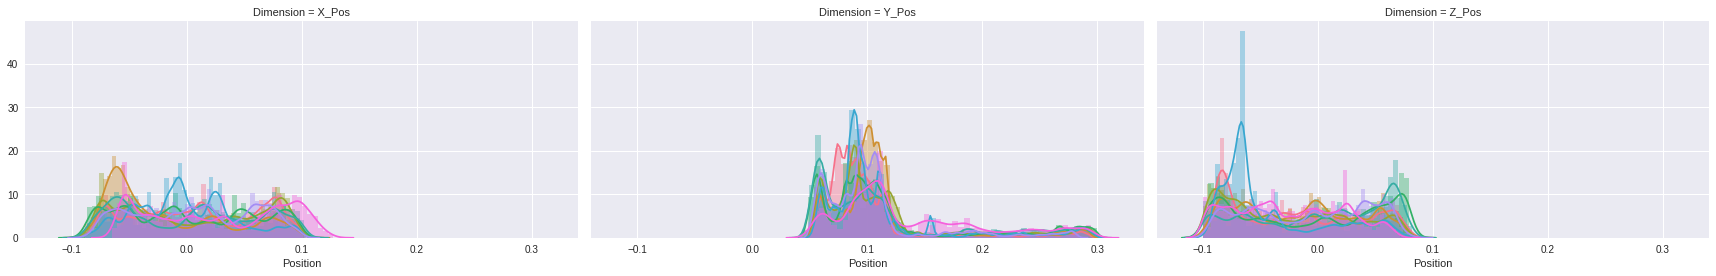

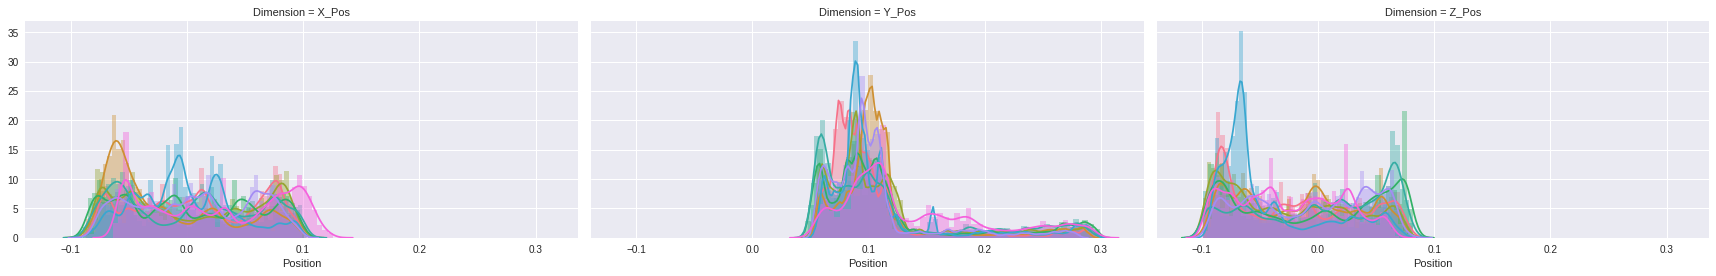

In [16]:
g = sns.FacetGrid(hue='session_id', col='Dimension', data=pos_l, size=4, aspect=2)
g.map(sns.distplot, 'Position');

g = sns.FacetGrid(hue='session_id', col='Dimension', data=pos_lSM, size=4, aspect=2)
g.map(sns.distplot, 'Position');

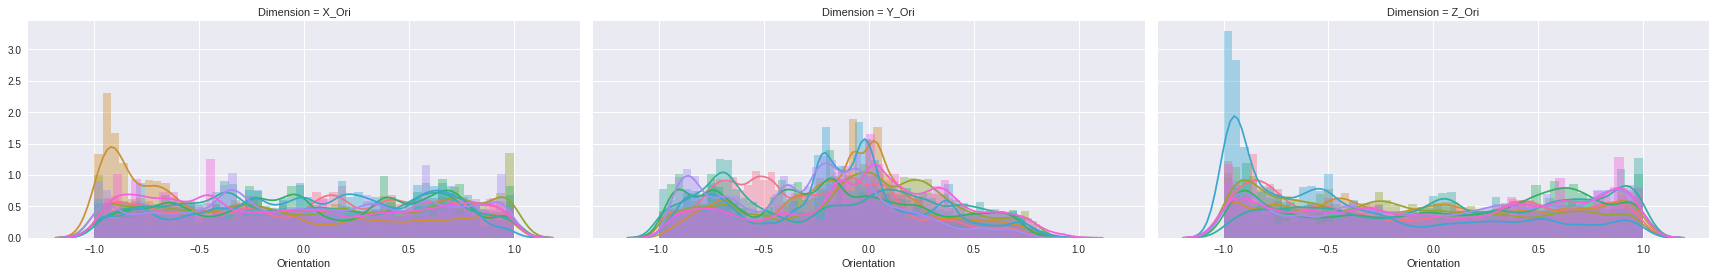

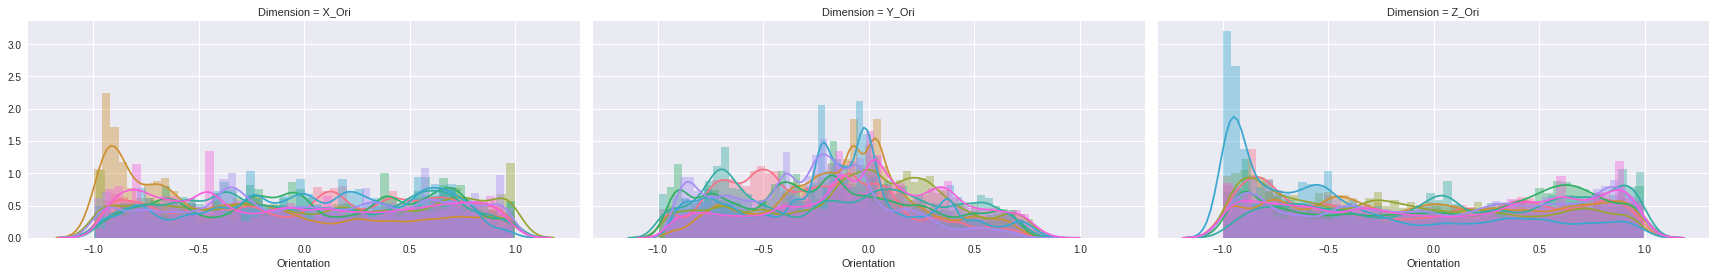

In [17]:
g = sns.FacetGrid(hue='session_id', col='Dimension', data=ori_l, size=4, aspect=2)
g.map(sns.distplot, 'Orientation');

g = sns.FacetGrid(hue='session_id', col='Dimension', data=ori_lSM, size=4, aspect=2)
g.map(sns.distplot, 'Orientation');


# Head Velocity
Notebook for clean attempt of checking the distribution of head velocity including the direction.

## Velocity - rapid movement removal
Removal based on speed of changes in the position of the animal - low pass filter of diagonal velocity.

In [18]:
pd.options.mode.chained_assignment = None 

#extraction of speed of positon changes and calculating velocity in all axes
dfPos = pd.DataFrame()
dfV = df.copy().dropna()
colList = ['Time', 'X_Pos', 'Y_Pos', 'Z_Pos']
dcolList = ['dT', 'dX_Pos', 'dY_Pos', 'dZ_Pos']

for name, dd in dfV.groupby('session_id'):
    dd[dcolList] = dd[colList].diff(-1)    
    dd['Vx_Pos'] = dd['dX_Pos'] / dd['dT']
    dd['Vy_Pos'] = dd['dY_Pos'] / dd['dT']
    dd['Vz_Pos'] = dd['dZ_Pos'] / dd['dT']
    dd['Vxyz_Pos'] = np.linalg.norm(dd[['Vx_Pos', 'Vy_Pos', 'Vz_Pos']].values, axis=1) # diagonal velocity
    
    
#     dd[['Vx_Pos', 'Vy_Pos', 'Vz_Pos']] = dd[['dX_Pos', 'dY_Pos', 'dZ_Pos']]  / dd['dT']
#     DL = np.array([dd['Vx_Pos'], dd['Vy_Pos'], dd['Vz_Pos']])
#     dd['Vxyz_Pos'] = np.linalg.norm(DL, axis=1) # diagonal velocity
    

    dfPos = pd.concat([dfPos, dd], axis=0, ignore_index=True)

dfPos = dfPos.replace([np.inf, -np.inf], np.nan).dropna()
# dfPos.Vxyz_Pos


200


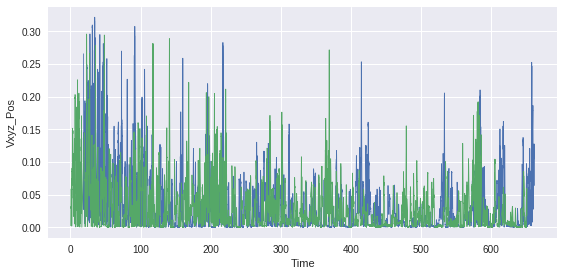

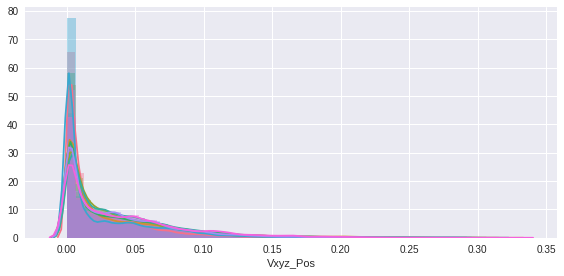

In [19]:
## POSITION VXYZ VELOCITY -  CAN BE CUT MORE

print(windowsize)
g = sns.FacetGrid(hue='session_id', data=dfPos, size=4, aspect=2, hue_order=[1,2])
g.map(plt.plot, "Time", "Vxyz_Pos", alpha=1, linewidth=0.8);

g = sns.FacetGrid(hue='session_id', data=dfPos, size=4, aspect=2)#, hue_order=[1,2])
g.map(sns.distplot, 'Vxyz_Pos');


In [20]:
#extraction of speed of orientation changes and calculating velocity in all axes
dfOri = pd.DataFrame()
dfV = df.copy()
colList = ['Time', 'X_Ori', 'Y_Ori', 'Z_Ori']
dcolList = ['dT', 'dX_Ori', 'dY_Ori', 'dZ_Ori']

for name, dd in dfV.groupby('session_id'):
    dd[dcolList] = dd[colList].diff(-1)    
    dd['Vx_Ori'] = dd['dX_Ori'] / dd['dT']
    dd['Vy_Ori'] = dd['dY_Ori'] / dd['dT']
    dd['Vz_Ori'] = dd['dZ_Ori'] / dd['dT']
    dd['Vxyz_Ori'] = np.linalg.norm(dd[['Vx_Ori', 'Vy_Ori', 'Vz_Ori']].values, axis=1) # diagonal velocity
    dfOri = pd.concat([dfOri, dd], axis=0, ignore_index=True)

dfOri = dfOri.replace([np.inf, -np.inf], np.nan).dropna()


In [21]:
## ORIENTATION VXYZ VELOCITY - FALSE TO CALCULATE IT WITH THIS, NEED OF GOIING TO ANGLES, OR CHECKING IF THEY STAY UNIT VECTOR

# g = sns.FacetGrid(hue='session_id', data=dfOri, size=4, aspect=2, hue_order=[1,2])
# g.map(plt.plot, "Time", "Vxyz_Ori", alpha=1, linewidth=0.8);

# g = sns.FacetGrid(hue='session_id', data=dfOri, size=4, aspect=2)
# g.map(sns.distplot, 'Vxyz_Ori');
